<a href="https://colab.research.google.com/github/Musu1/Deep-Learning/blob/master/BatchNorm_DropOut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns

#DataSet and visualisation

In [0]:
transform_train=transforms.Compose([transforms.ToTensor(),])

In [0]:
trainset=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor())
# Dataset is to recognize numbers in an image. So I am using MNIST dataset

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 27546678.26it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 474708.24it/s]
  1%|          | 16384/1648877 [00:00<00:11, 143986.00it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 7590455.70it/s]                            
8192it [00:00, 188598.06it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
batch_size=4

In [0]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [0]:
dataiter=iter(trainloader)
images,labels=dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels[0].item())
# The images in the dataset are gray scale that is single channel and 28x28 image.

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
1


In [0]:
def imshow(img,title):
  plt.figure(figsize=(batch_size*4,4))
  plt.axis('off')
  plt.imshow(np.transpose(img,(1,2,0)))
  plt.title(title)
  plt.show()

In [0]:
def show_batch_images(dataloader):
  images,labels=next(iter(dataloader))
  img=torchvision.utils.make_grid(images)
  imshow(img,title=[str(x.item()) for x in labels])
  return images,labels

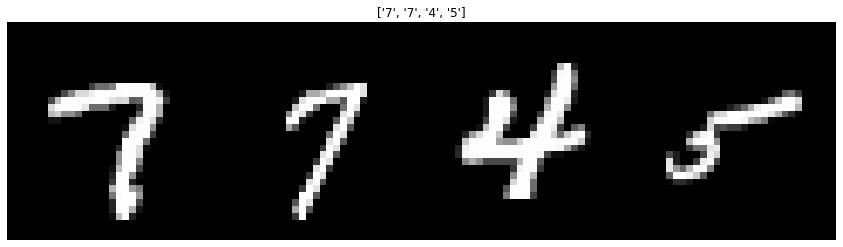

In [0]:
images,labels=show_batch_images(trainloader)

# Batchnorm

In [0]:
class MyNet(nn.Module):
  def __init__(self):
    super(MyNet,self).__init__()
    self.classifier=nn.Sequential(
        nn.Linear(784,48), # since image is 28x28=784
        nn.ReLU(), # Applying nonlinearity
        nn.Linear(48,24),
        nn.ReLU(),
        nn.Linear(24,10) # Final output in 10 classes
    )

  def forward(self,x):
    x=x.view(x.size(0),-1)
    x=self.classifier(x)
    return x

In [0]:
class MyNetBN(nn.Module):
  def __init__(self):
    super(MyNetBN,self).__init__()
    self.classifier=nn.Sequential(
        nn.Linear(784,48), # since image is 28x28=784
        nn.BatchNorm1d(48), #BatchNorm input is number of channels 
        nn.ReLU(), # Applying nonlinearity
        nn.Linear(48,24),
        nn.BatchNorm1d(24),
        nn.ReLU(),
        nn.Linear(24,10) # Final output in 10 classes
    )

  def forward(self,x):
    x=x.view(x.size(0),-1)
    x=self.classifier(x)
    return x

In [0]:
model=MyNet()
print(model)

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [0]:
model_bn=MyNetBN()
print(model_bn)

MyNetBN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [0]:
batch_size=512

In [0]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [0]:
# Here we will be training two models simultaneously
loss_fn=nn.CrossEntropyLoss()
opt=optim.SGD(model.parameters(),lr=0.001)
opt_bn=optim.SGD(model_bn.parameters(),lr=0.001)

0.0032683972 0.11837311 0.027140578 0.095467456


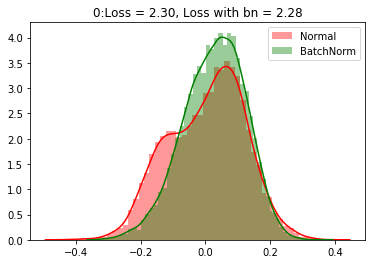

0.0042910078 0.12205891 0.005492831 0.99180835


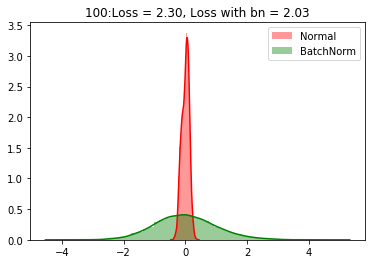

0.004060462 0.12087086 0.0050159283 0.99772215


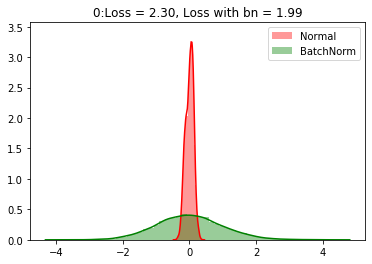

0.0055091623 0.12231905 0.0039706747 0.99288934


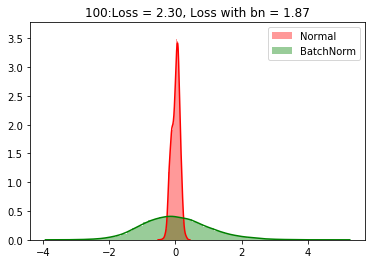

---------------------------------


In [0]:
loss_arr=[]
loss_bn_arr=[]

max_epochs=2

for epoch in range(max_epochs):
  for i,data in enumerate(trainloader,0):
    inputs,labels=data

    # training steps for normal model
    opt.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    opt.step()

    # training stes for batch norm model
    opt_bn.zero_grad()
    outputs_bn=model_bn(inputs)
    loss_bn=loss_fn(outputs_bn,labels)
    loss_bn.backward()
    opt_bn.step()

    loss_arr.append(loss.item())
    loss_bn_arr.append(loss_bn.item())

    if i%100==0:
      inputs=inputs.view(inputs.size(0),-1)

      model.eval()
      model_bn.eval()

      a=model.classifier[0](inputs)
      a=model.classifier[1](a)
      a=model.classifier[2](a)
      a=a.detach().numpy().ravel()
      sns.distplot(a,kde=True,color='r',label='Normal')

      b=model_bn.classifier[0](inputs)
      b=model_bn.classifier[1](b)
      b=model_bn.classifier[2](b)
      b=model_bn.classifier[3](b)
      b=model_bn.classifier[4](b)
      b=b.detach().numpy().ravel()

      sns.distplot(b,kde=True,color='g',label='BatchNorm')
      print(np.mean(a),np.std(a),np.mean(b),np.std(b))
      plt.title('%d:Loss = %0.2f, Loss with bn = %0.2f' % (i,loss.item(),loss_bn.item()))
      plt.legend()
      plt.show()
      plt.pause(0.5)

      model.train()
      model_bn.train()

print('---------------------------------')